## Example script for training the L2HMC sampler

## Imports / setup for training

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import datetime
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
try:
    import horovod
    import horovod.tensorflow as hvd
    try:
        RANK = hvd.rank()
    except ValueError:
        hvd.init()
        
    RANK = hvd.rank()
    HAS_HOROVOD = True
    logging.info(f'Using horovod version: {horovod.__version__}')
    logging.info(f'Using horovod from: {horovod.__file__}')
    GPUS = tf.config.experimental.list_physical_devices('GPU')
    for gpu in GPUS:
        tf.config.experimental.set_memory_growth(gpu, True)
    if GPUS:
        gpu = GPUS[hvd.local_rank()]
        tf.config.experimental.set_visible_devices(gpu, 'GPU')
except ImportError:
    HAS_HOROVOD = False

import tensorflow as tf
from rich.console import Console
from rich.theme import Theme
from rich import print

if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))
    
sns.set_palette('bright')

plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('bright')

plt.rc('text', usetex=True)

console = Console(theme=Theme({"repr.number": "#ff79ff"}),
                  force_jupyter=True, 
                  width=180, log_time=True, log_time_format='[%X]')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load configs from `BIN_DIR/train_configs.json`:

In [5]:
import json
from config import BIN_DIR

train_configs_file = os.path.join(BIN_DIR, 'train_configs.json')
with open(train_configs_file, 'rt') as f:
    configs = json.load(f)
    
configs.update({
    'train_steps': 5000,
    'run_steps': 1000,
    'save_steps': 1000,
    'steps_per_epoch': 50,
    'patience': 5,
    'min_lr': 1e-4,
    'logging_steps': 100,
    'print_steps': 5,
    'beta_init': 3.,
    'beta_final': 3.,
})

configs['dynamics_config'].update({
    'num_steps': 9,
    'x_shape': [512, 8, 8, 2],
    'net_weights': [1., 1., 1., 1., 1., 1.],
})

console.log(configs)

Get timestamp and create `log_dir` where everything will live

In [6]:
import utils.file_io as io
from utils.attr_dict import AttrDict

io.console = console

# Keep history of `log_dir` for later reference
log_file = os.path.join(os.getcwd(), 'log_dirs.txt')

configs = AttrDict(configs)

timestamps = AttrDict({
    'month': io.get_timestamp('%Y_%m'),
    'time': io.get_timestamp('%Y-%m-%d-%H%M%S'),
    'hour': io.get_timestamp('%Y-%m-%d-%H'),
    'minute': io.get_timestamp('%Y-%m-%d-%H%M'),
    'second': io.get_timestamp('%Y-%m-%d-%H%M%S'),
})

log_dir = io.make_log_dir(configs, 'GaugeModel', log_file,
                          timestamps=timestamps)
configs.log_dir = log_dir
io.write(f'{configs.log_dir}', log_file, 'a')

## Run training:

To demonstrate that everything is working correctly, we only train for `configs.train_steps = 100` training steps.

In [7]:
from utils.training_utils import train 

# Only make plots for 8 chains to speed up plotting
num_chains_to_plot = 12 

# Draw initial x uniformly from [-pi, pi]:
x_shape = configs.dynamics_config.get('x_shape', None)
x = tf.random.uniform(x_shape, minval=-np.pi, maxval=np.pi)
x = tf.reshape(x, (x.shape[0], -1))

x, dynamics, train_data, configs = train(configs,
                                         x=x, make_plots=False,
                                         num_chains=num_chains_to_plot,
                                         should_track=False)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=1601>): Reducing learning rate from: 0.0010000000474974513 to 0.0009900000470224768.
current: -4.326971054077148, best: -4.563868045806885


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=2801>): Reducing learning rate from: 0.0009900000877678394 to 0.000980100086890161.
current: -7.817276477813721, best: -8.160100936889648


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=3901>): Reducing learning rate from: 0.000980100128799677 to 0.0009702991275116801.
current: -17.299072265625, best: -18.61933708190918


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=4451>): Reducing learning rate from: 0.0009702991228550673 to 0.0009605961316265165.
current: -17.732587814331055, best: -22.074628829956055


ReduceLROnPlateau (step <tf.Variable 'iter:0' shape=() dtype=int64, numpy=4851>): Reducing learning rate from: 0.0009605961386114359 to 0.0009509901772253215.
current: -20.8505802154541, best: -24.079505920410156


### Make plots from training data
---

Explicitly, we look at the how the following quantities evolve during training:

1. The various stepsizes, $\varepsilon_{x},\, \varepsilon_{v}$

2. The error in the average plaquette: $\langle\delta\varphi_{P}\rangle \equiv \varphi_{P}^{*} - \langle\varphi_{P}\rangle$

where $\varphi_{P}^{*}$ is the exact result from the infinite volume limit, and is given by

\begin{equation}
\varphi_{P}^{*}(\beta) = \frac{I_{1}(\beta)}{I_{0}(\beta)}
\end{equation}

3. The error in the average $4\times4$ Wilson loop $\langle\mathcal{W}_{4\times4}\rangle$

4. The `sumlogdet`, overall Jacobian factor 

\begin{equation}
\sum\left|\mathcal{J}\right| = \left|\frac{\partial\xi^{\prime}}{\partial\xi^{T}}\right|
\end{equation}
   

5. The acceptance probability 

\begin{equation}
A(\xi^{\prime}|\xi) = \min\left\{1, \frac{p(\xi^{\prime})}{p(\xi)}\left|\frac{\partial\xi^{\prime}}{\partial\xi^{T}}\right|\right\}
\end{equation}

6. The integer-valued topological charge 

\begin{align}
\mathcal{Q}_{\mathbb{Z}} &\equiv \frac{1}{2\pi}\sum_{P}\left\lfloor\varphi_{P}\right\rfloor, \\
\left\lfloor\varphi_{P}\right\rfloor &\equiv \varphi_{P} - 2\pi\left\lfloor\frac{\varphi_{P}+\pi}{2\pi}\right\rfloor
\end{align}
   

7. The tunneling rate(s)  
\begin{equation}
    \delta_{\mathcal{Q}_{\mathcal{X}}}(\xi^{\prime}, \xi) \equiv |\mathcal{Q}_{\mathcal{X}}^{\prime} -  \mathcal{Q}_{\mathcal{X}}|
\end{equation}

for $\mathcal{X} \in \left\{\mathbb{R}, \mathbb{Z}\right\}$.

8. The loss 

\begin{equation}
\mathcal{L}_{\theta}(\xi, \xi^{\prime}, A(\xi^{\prime}|\xi)) 
= -A(\xi^{\prime}|\xi)\cdot \ell(\xi^{\prime},\xi)
\end{equation}

with

\begin{equation}
\ell(\xi, \xi^{\prime}) \equiv \frac{(\mathcal{Q}^{\prime}_{\mathbb{R}} - \mathcal{Q}_{\mathbb{R}})^{2}}{a^2} 
\end{equation}

and

\begin{equation}
\mathcal{Q}_{\mathbb{R}}(\varphi) = \frac{1}{2\pi}\sum_{P}\sin\varphi_{P}
\end{equation}

so

\begin{align}
\begin{split}
\mathcal{L}_{\theta} &= -A(\xi^{\prime}|\xi)\cdot\frac{1}{(2\pi a)^{2}}\left(%
 \mathcal{Q}_{\mathbb{R}}(\varphi^{\prime}) - \mathcal{Q}_{\mathbb{R}}(\varphi)\right)^{2} \\
 &=-A(\xi^{\prime}|\xi)\cdot\frac{1}{(2\pi\,a)^2}\left(\sum_{P}\sin\varphi_{P}^{\prime} - \sum_{P}\sin\varphi_{P}\right)^{2}
 \end{split}
 \end{align}
 



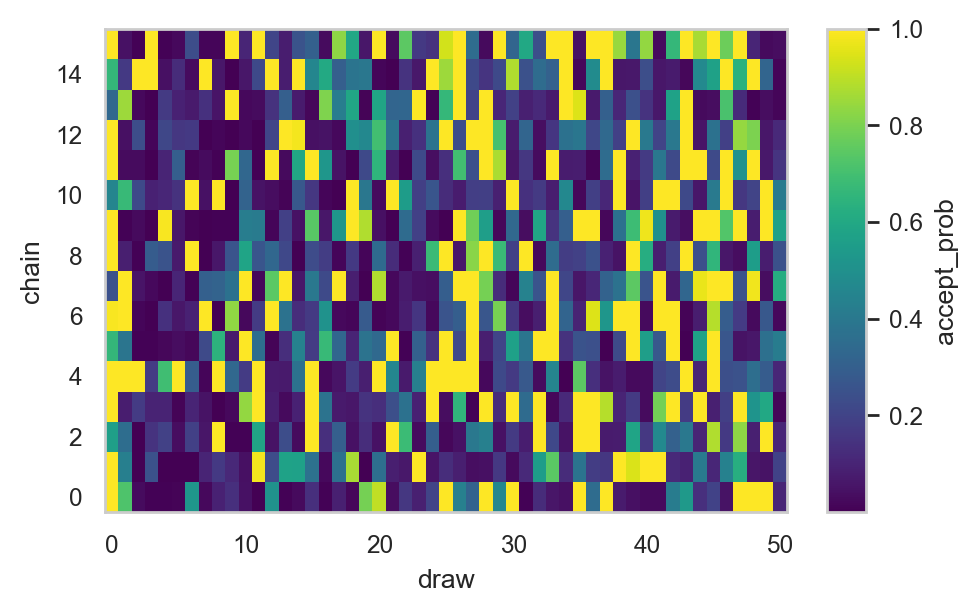

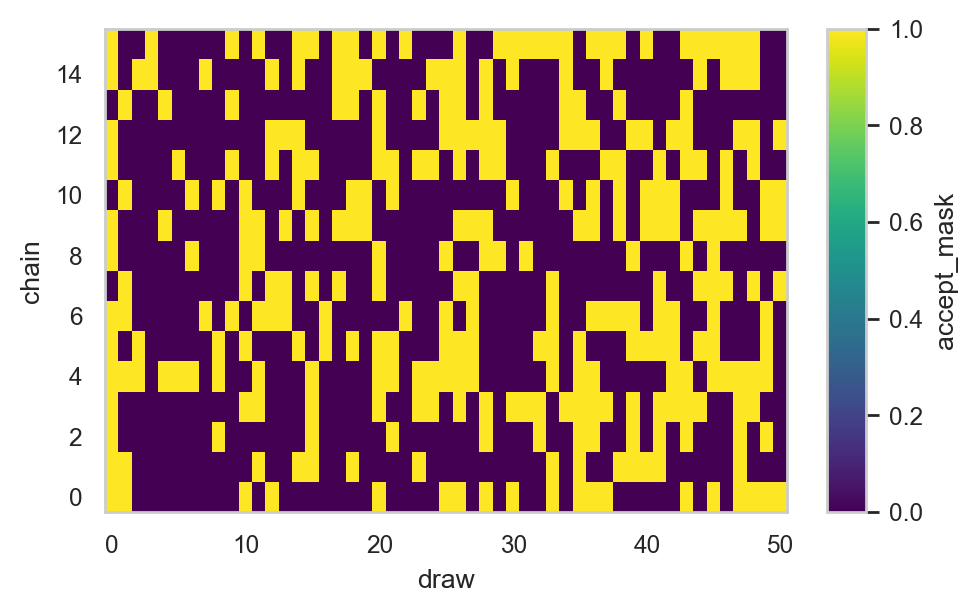

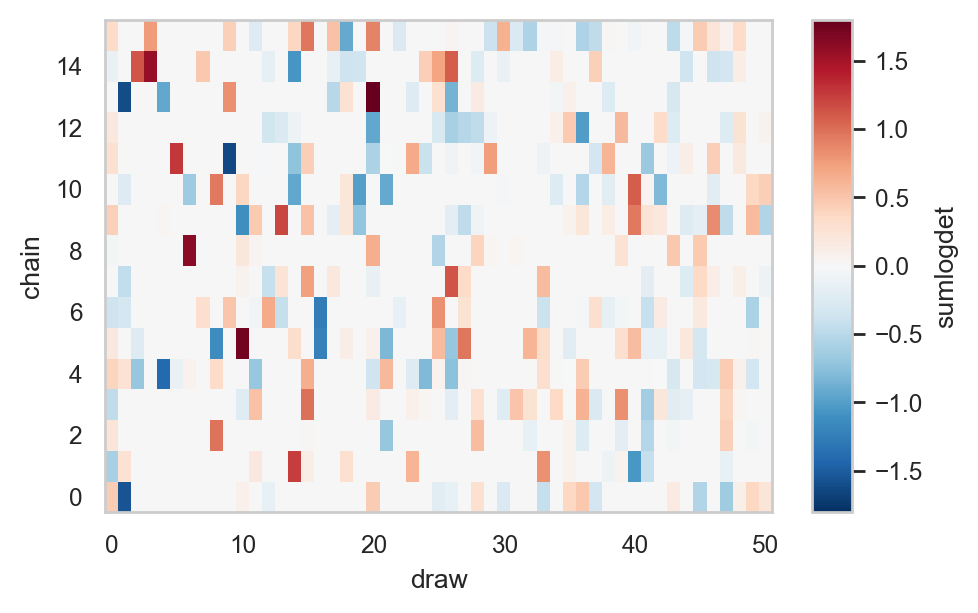

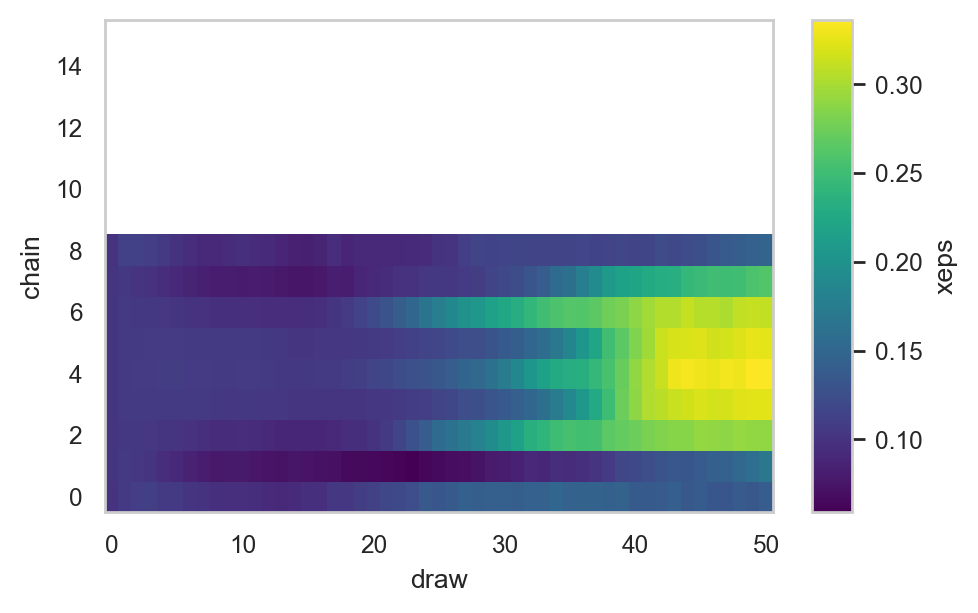

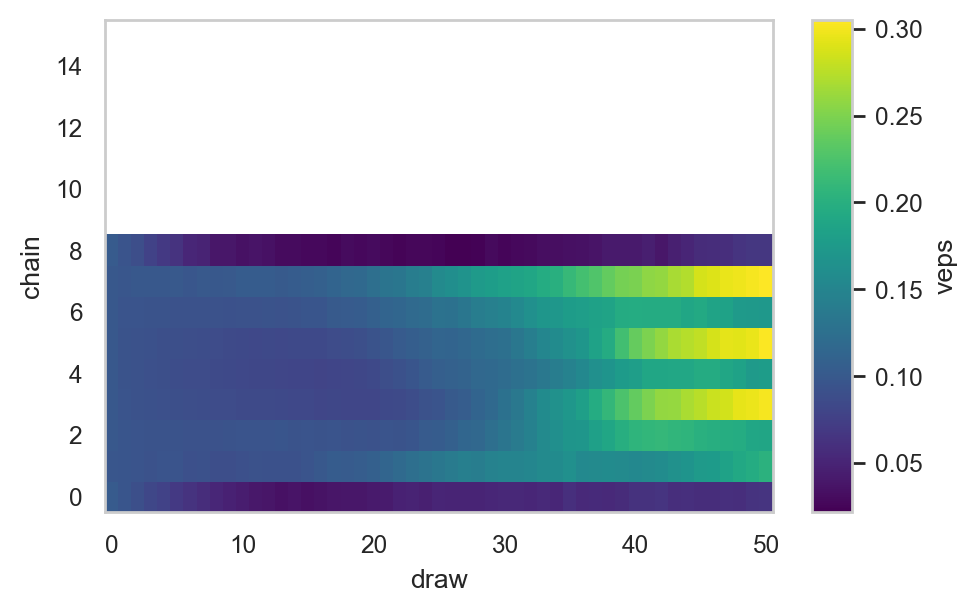

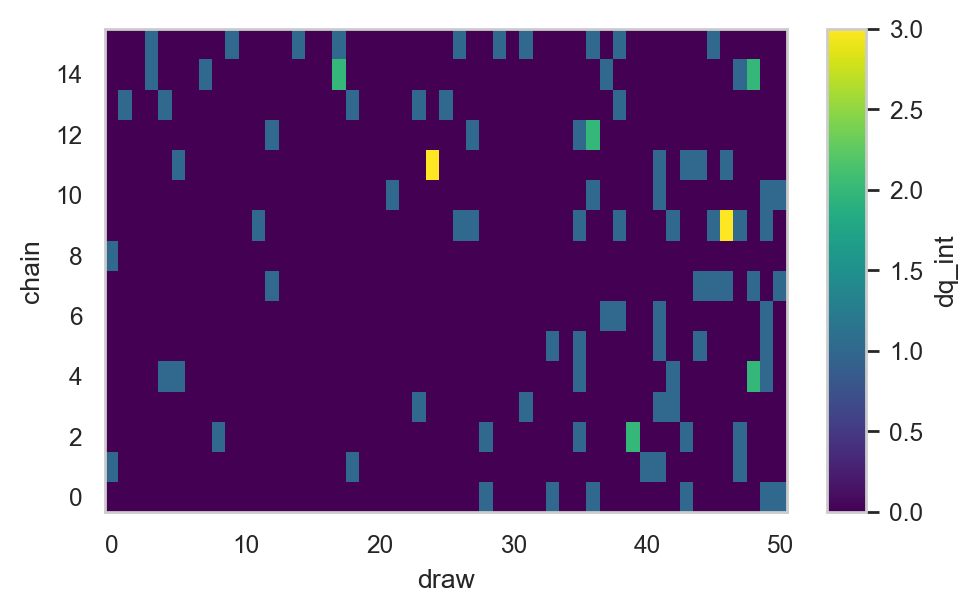

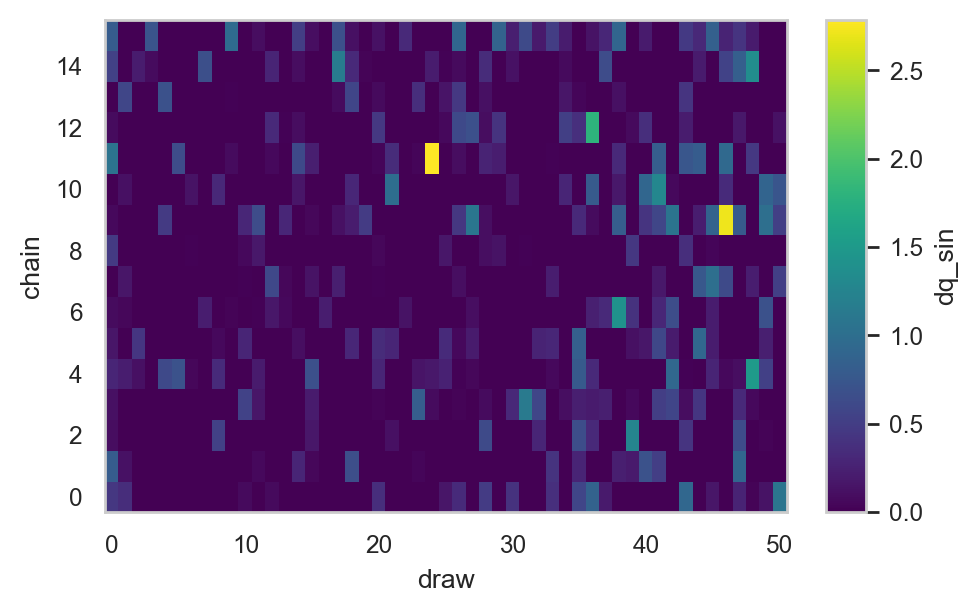

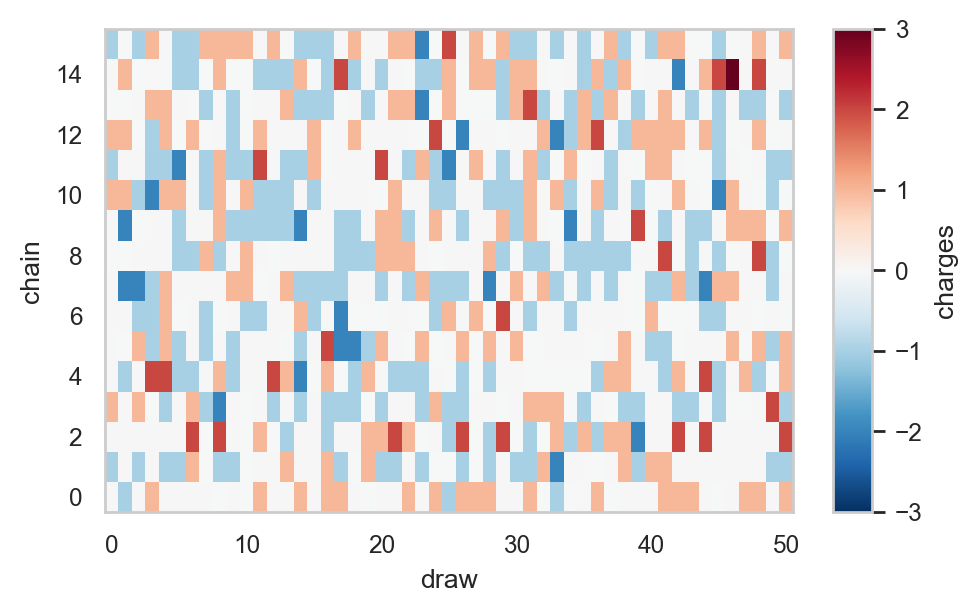

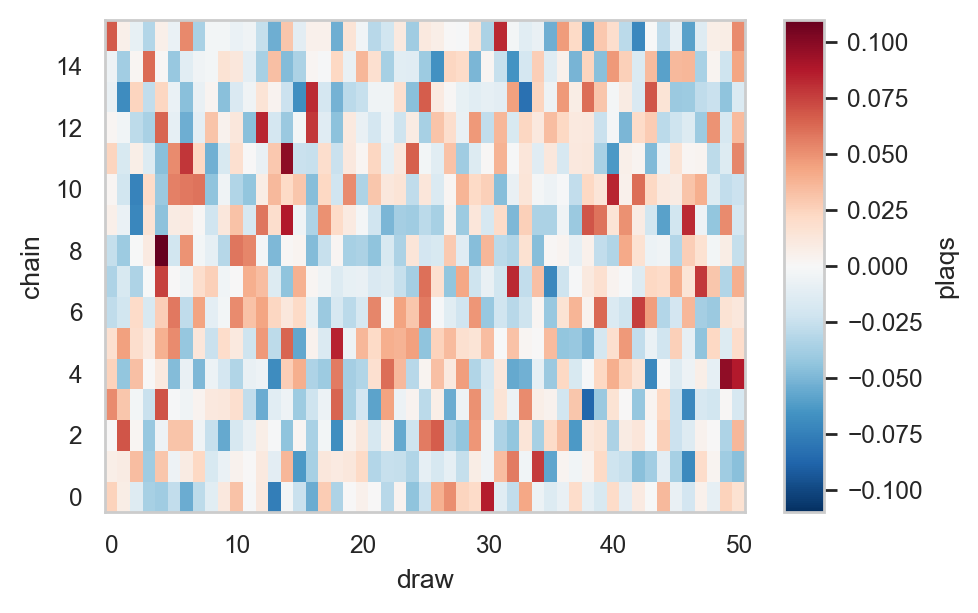

In [15]:
from utils.plotting_utils import set_size, make_ridgeplots

num_chains_to_plot = 16

to_plot = [
    'xeps', 'veps',
    'plaqs', 'p4x4'
    'loss', 'sumlogdet',
    'accept_prob', 'accept_mask',
    'charges', 'dq_int', 'dq_sin',
]


train_dataset = train_data.get_dataset(therm_frac=0.)
for key, val in train_dataset.data_vars.items():
    if key not in to_plot:
        continue
        
    val = val[:num_chains_to_plot]
    fig, ax = plt.subplots(constrained_layout=True, figsize=set_size())
    _ = val.plot(ax=ax)

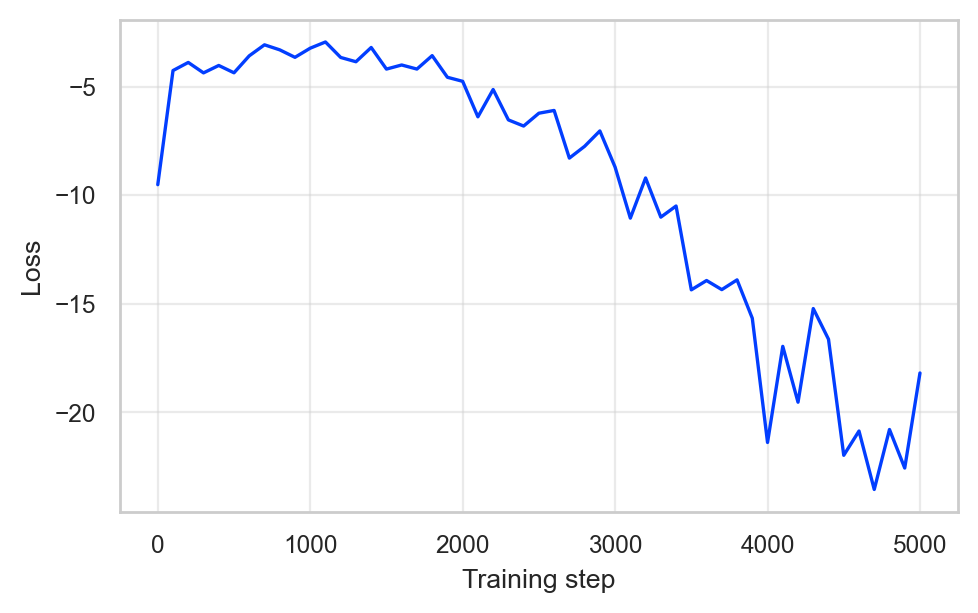

In [16]:
fig, ax = plt.subplots(constrained_layout=True, figsize=set_size())
_ = ax.plot(configs['logging_steps'] * np.arange(len(train_dataset.loss)), train_dataset.loss)
_ = ax.set_ylabel(f'Loss')
_ = ax.grid(True, alpha=0.4)
_ = ax.set_xlabel(f'Training step')

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  sel

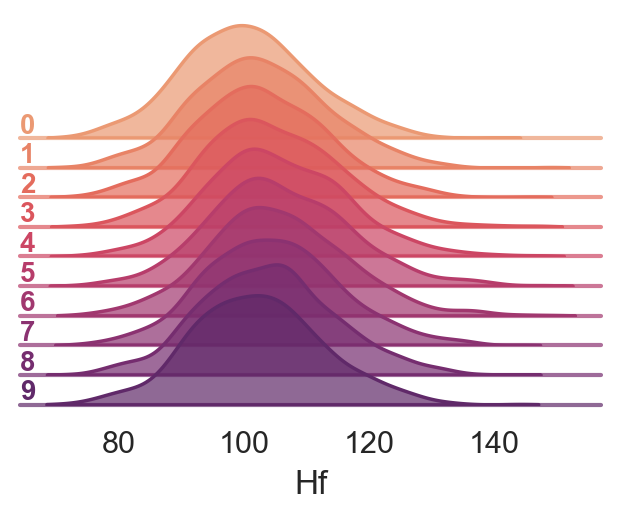

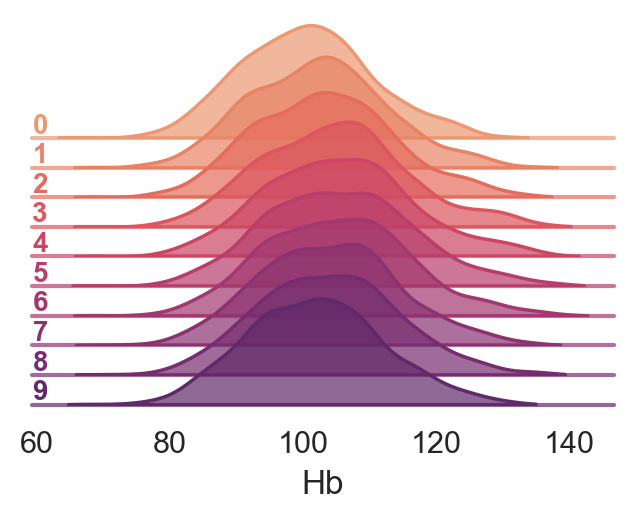

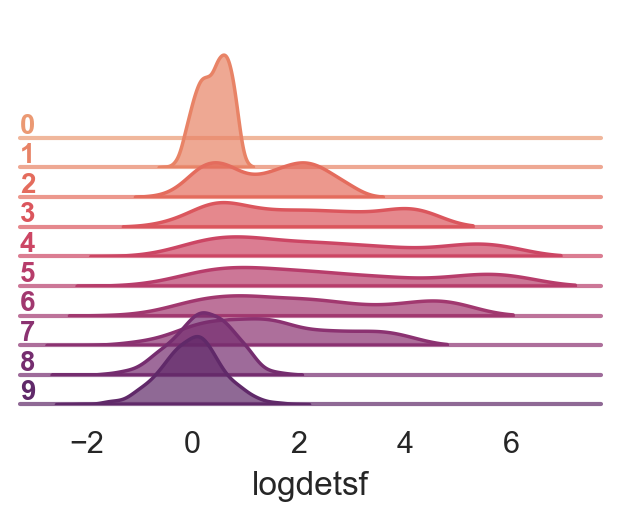

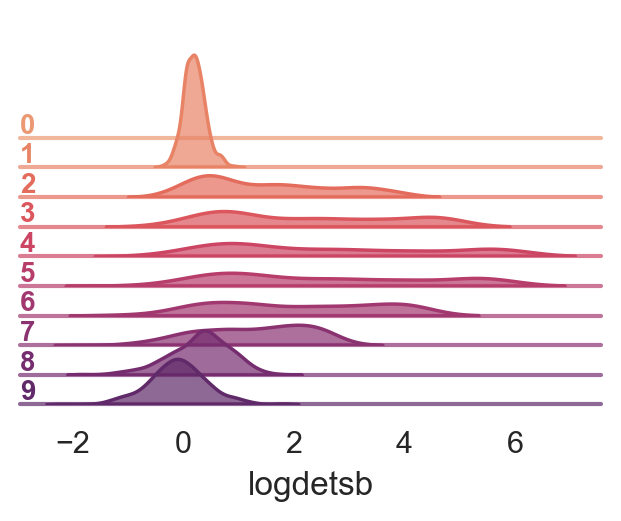

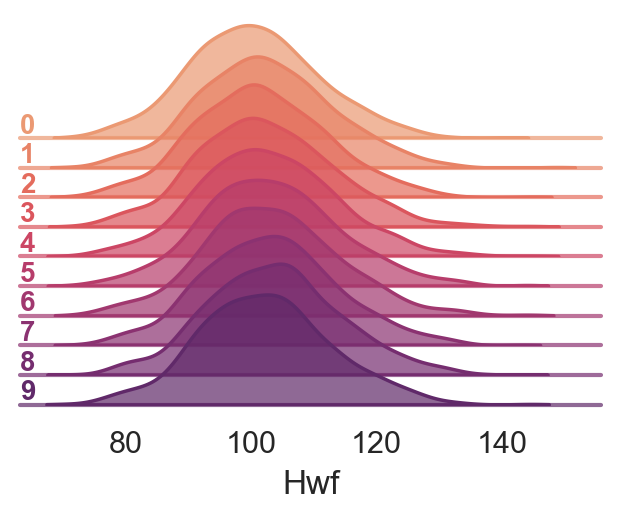

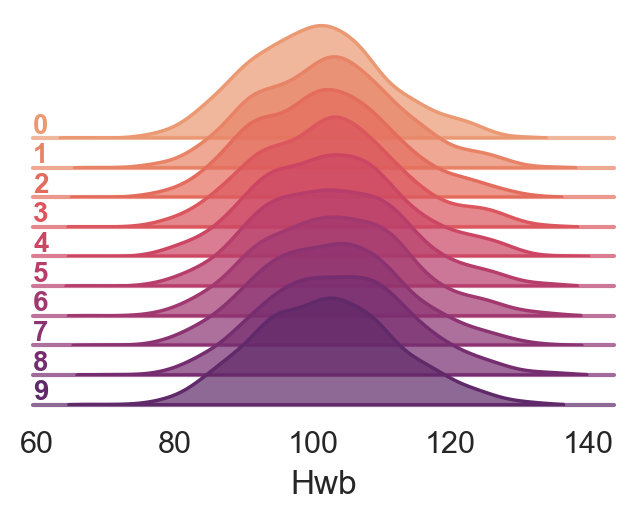

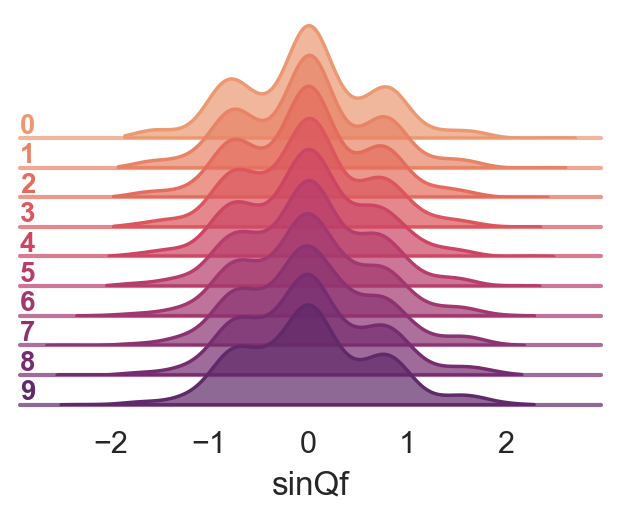

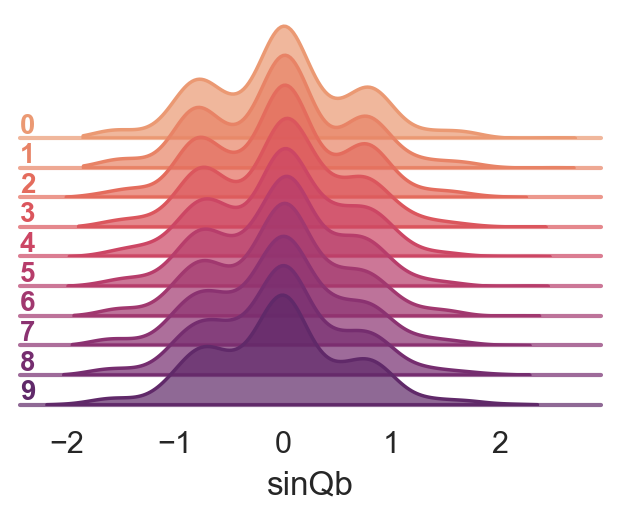

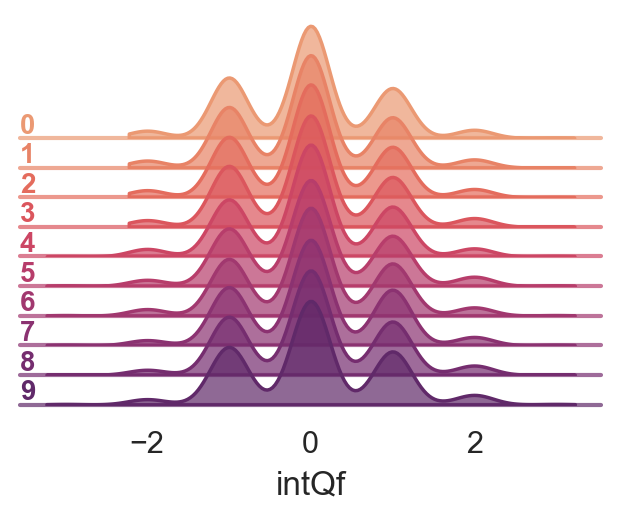

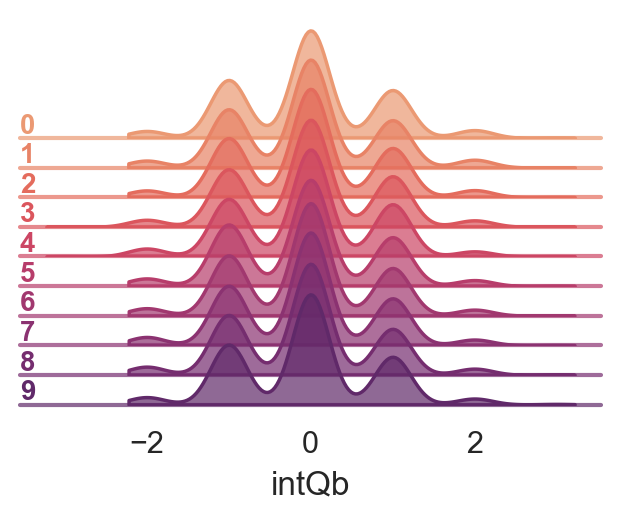

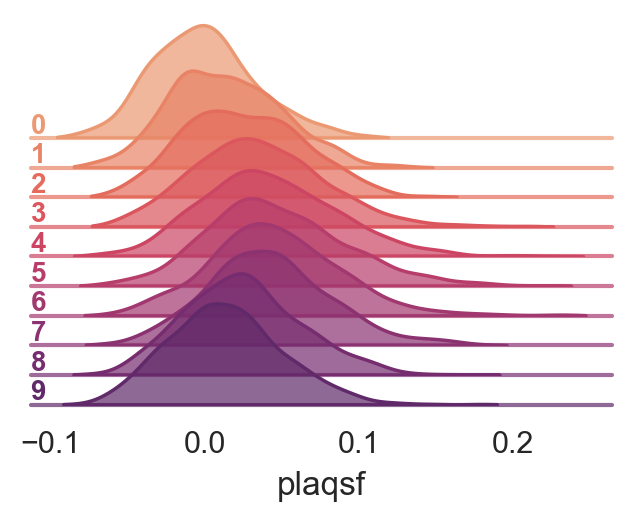

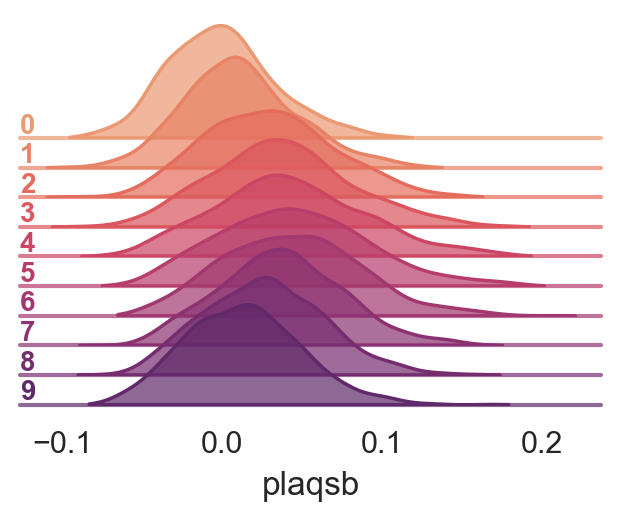

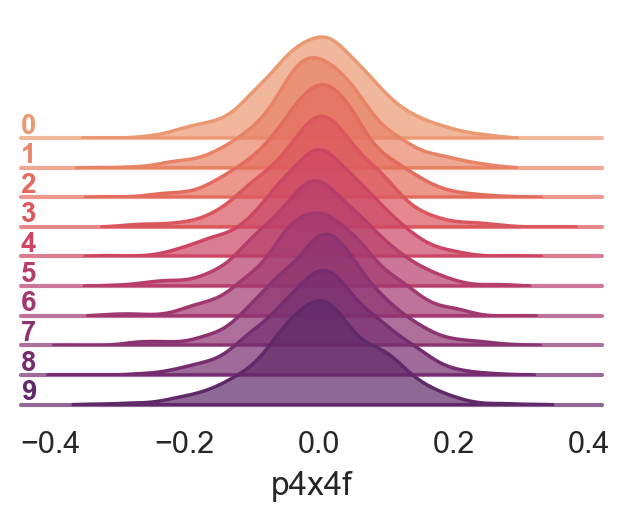

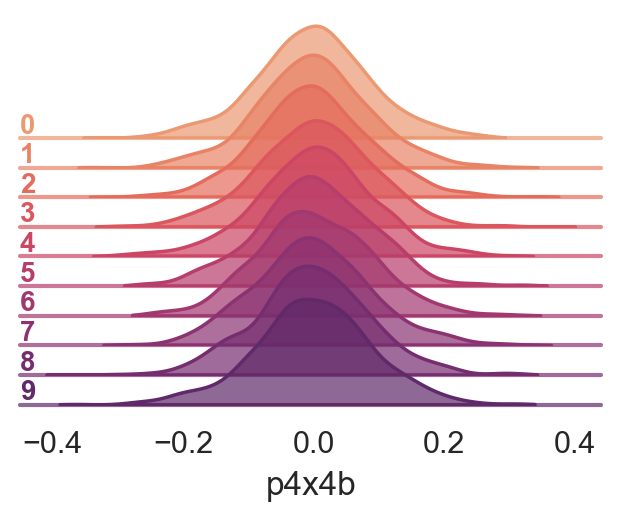

In [17]:
from utils.plotting_utils import make_ridgeplots
fig, ax = make_ridgeplots(train_dataset, num_chains_to_plot)

## Run inference using the trained model (`dynamics` object):

In [18]:
from utils.inference_utils import run as run_inference

if configs.get('run_steps', None) > 0:
    log_dir = configs.log_dir
    beta = configs.get('beta_final', None)
    inference_results = run_inference(dynamics=dynamics,  # pass the trained dynamics
                                      x=x,
                                      args=configs, 
                                      beta=beta,
                                      make_plots=True,
                                      therm_frac=0.2,
                                      num_chains=num_chains_to_plot,
                                      console=console,
                                      save_x=False)

/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)


/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout(*args, **kwargs)
/Users/saforem2/opt/anaconda3/envs/tf2.4/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  sel

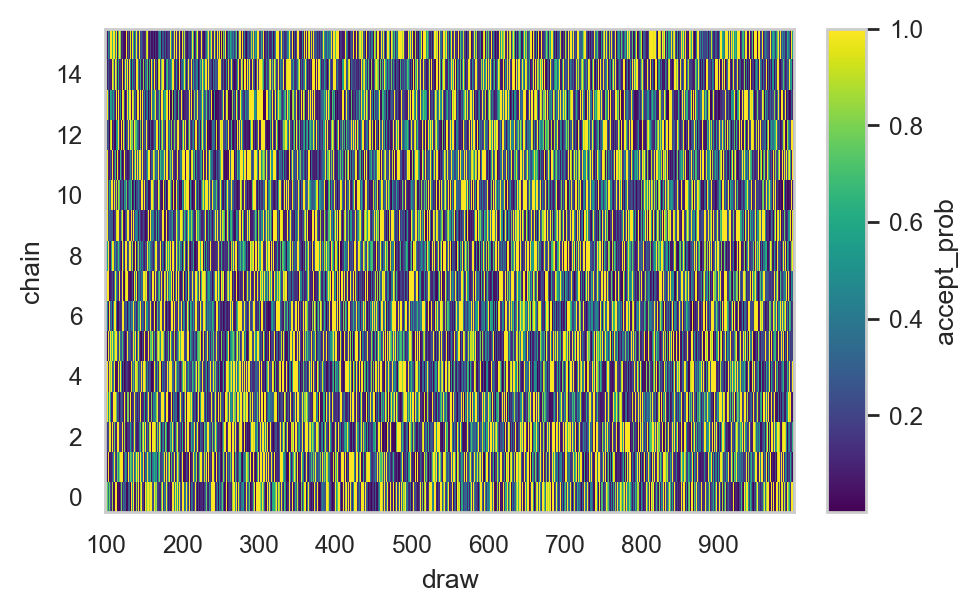

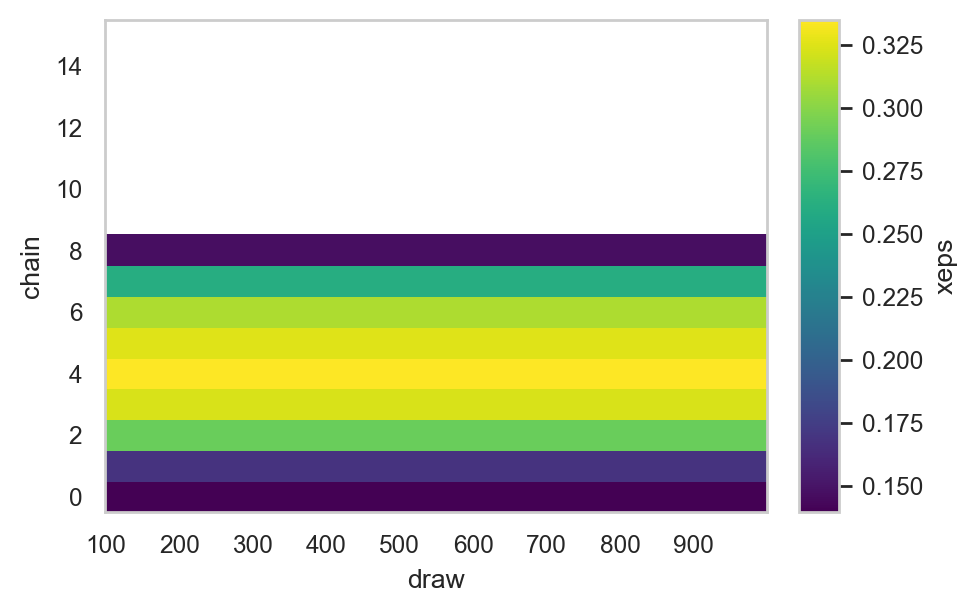

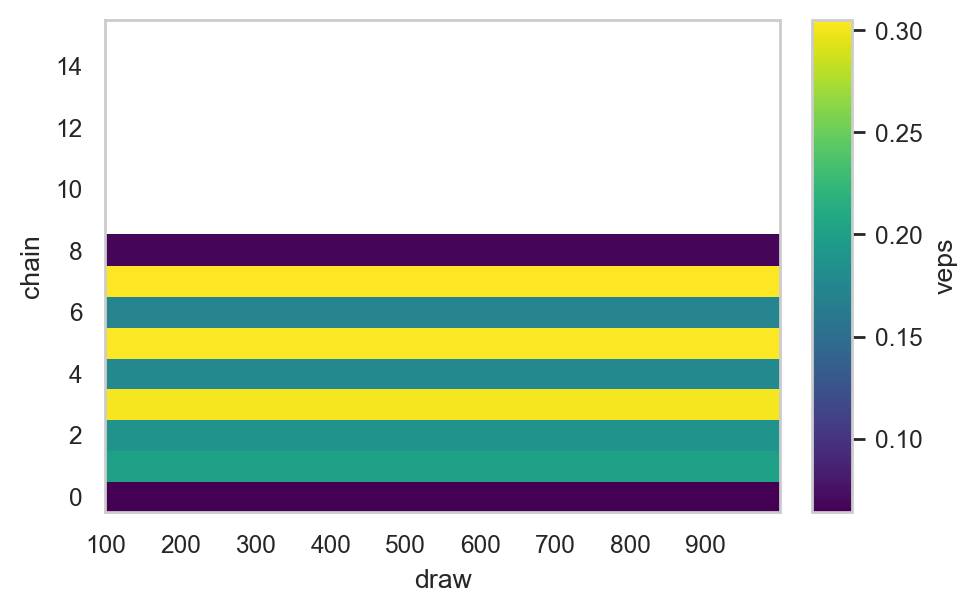

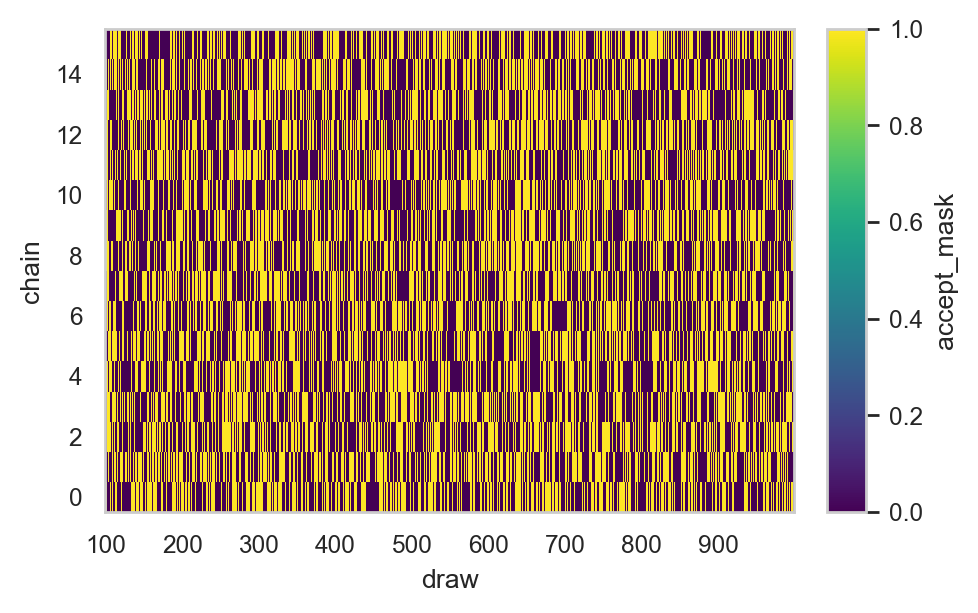

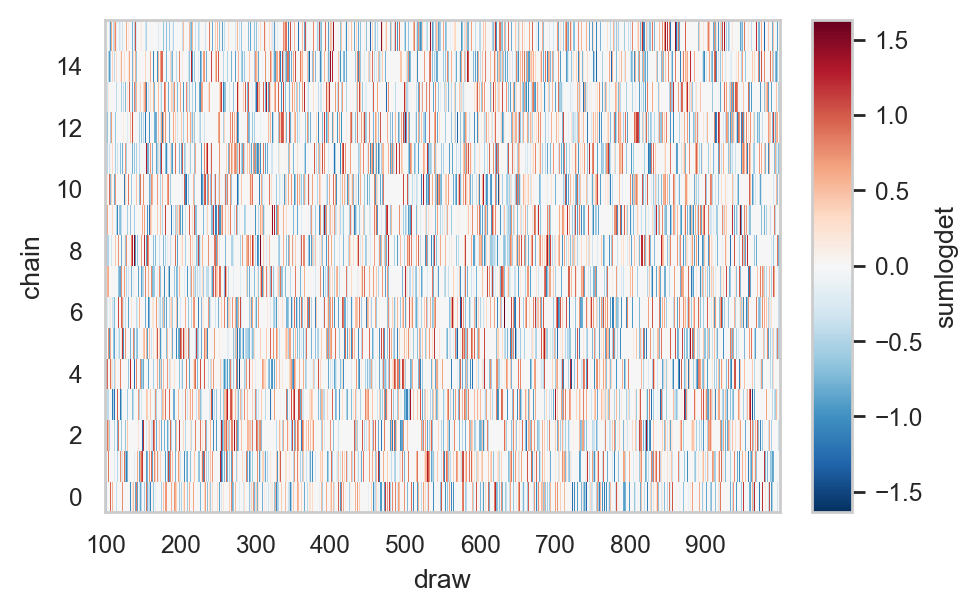

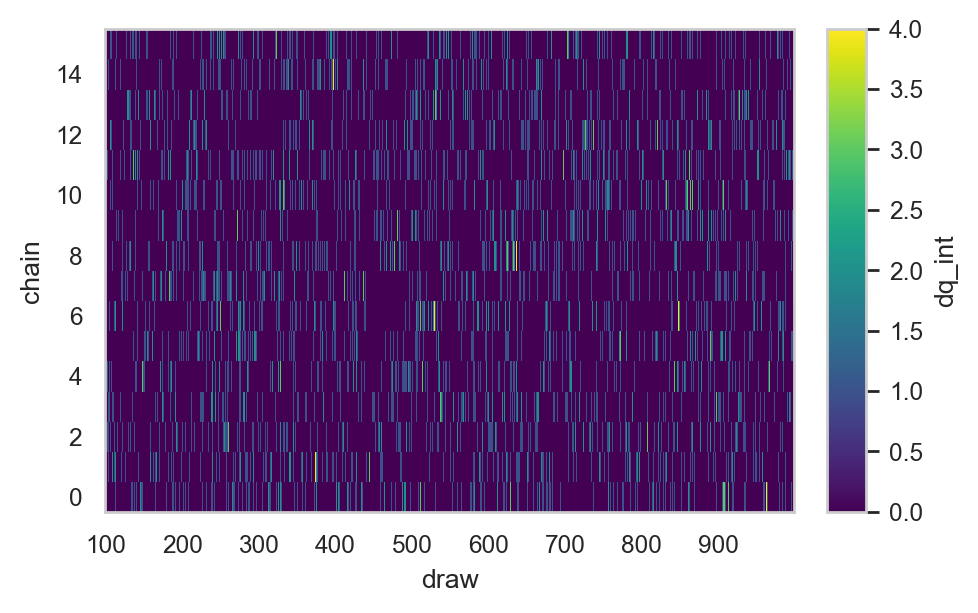

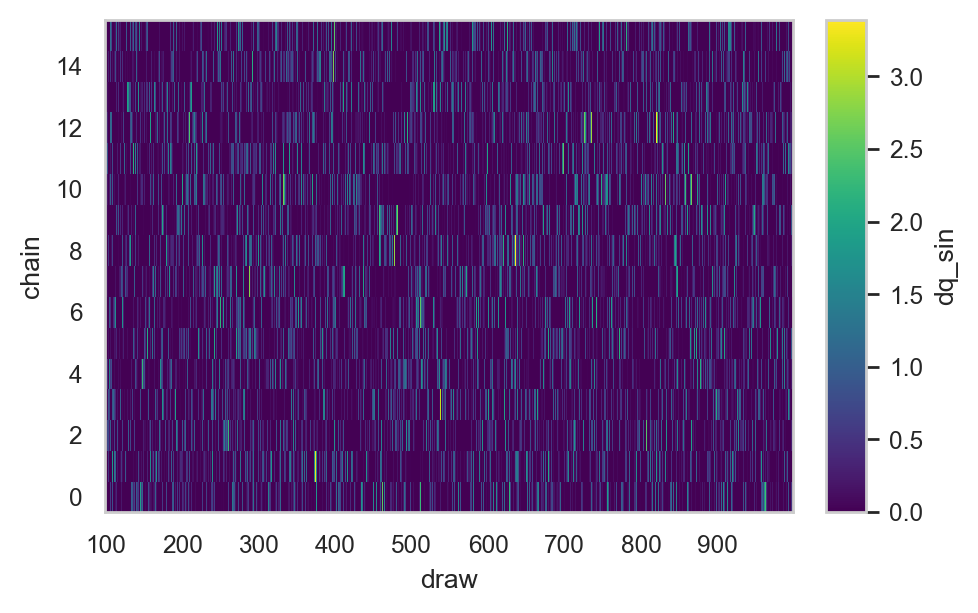

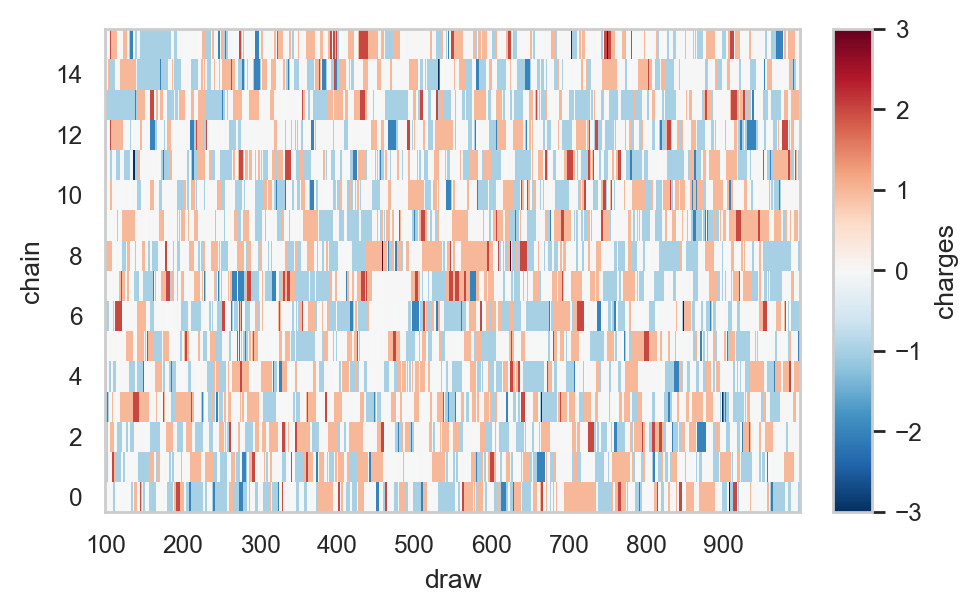

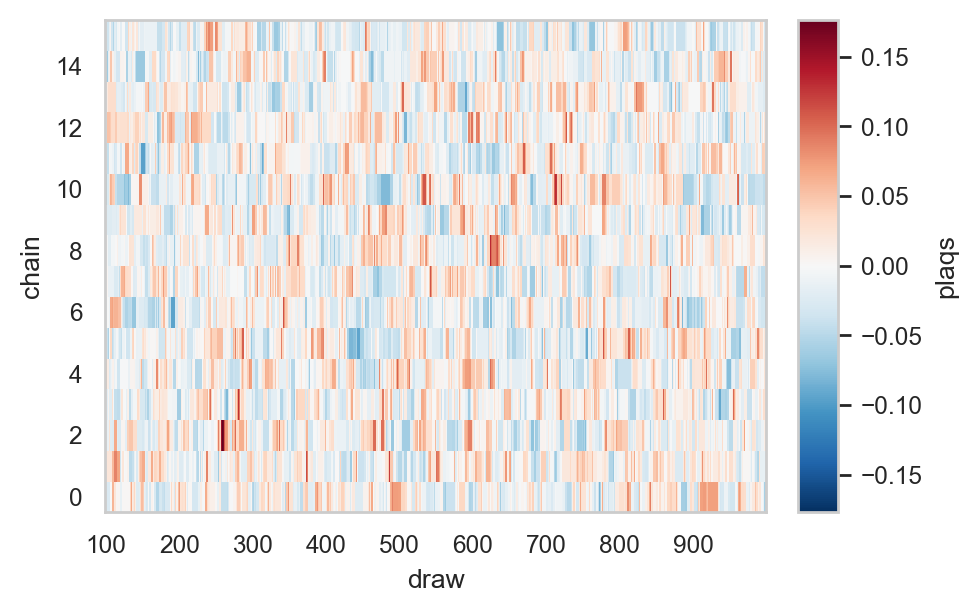

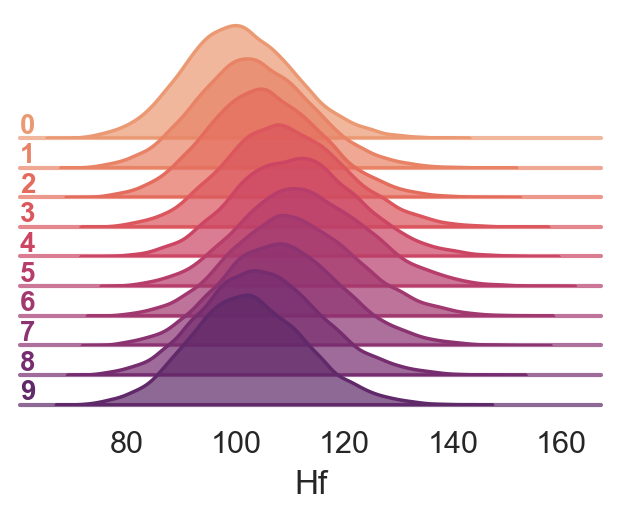

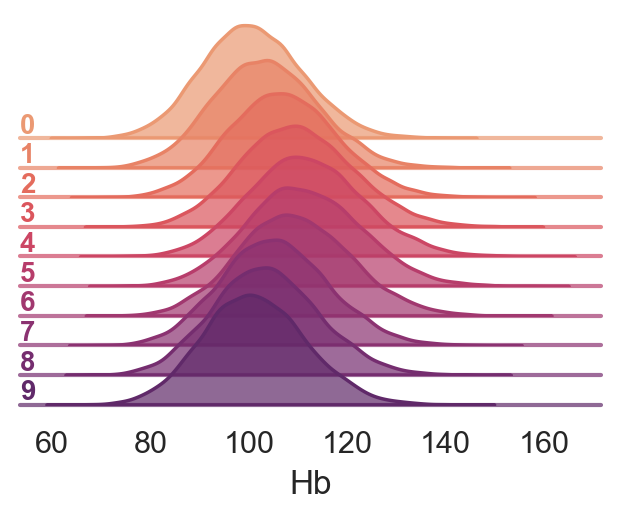

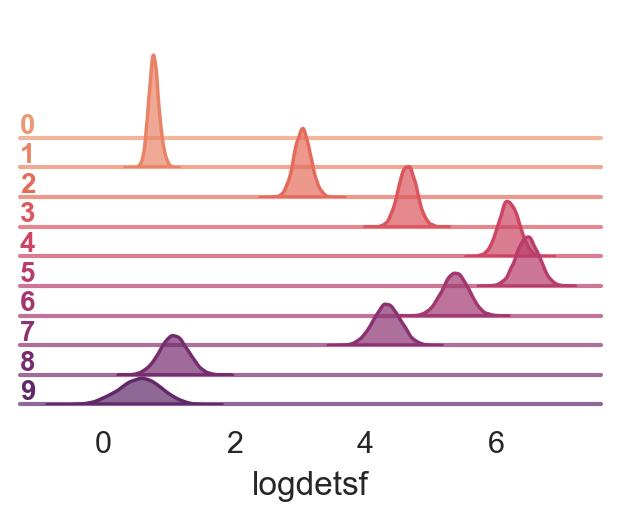

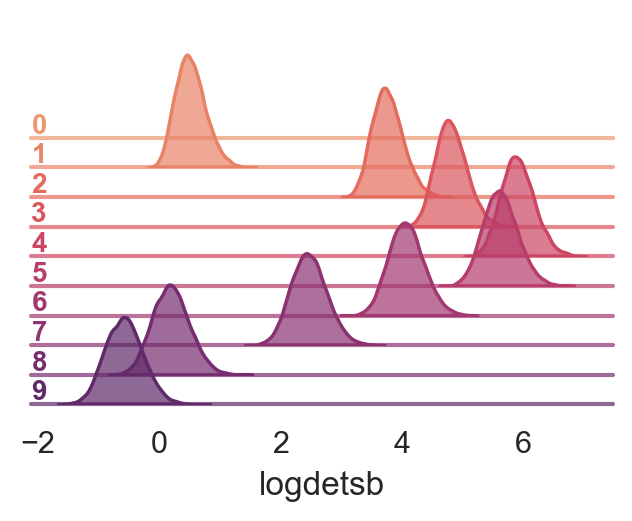

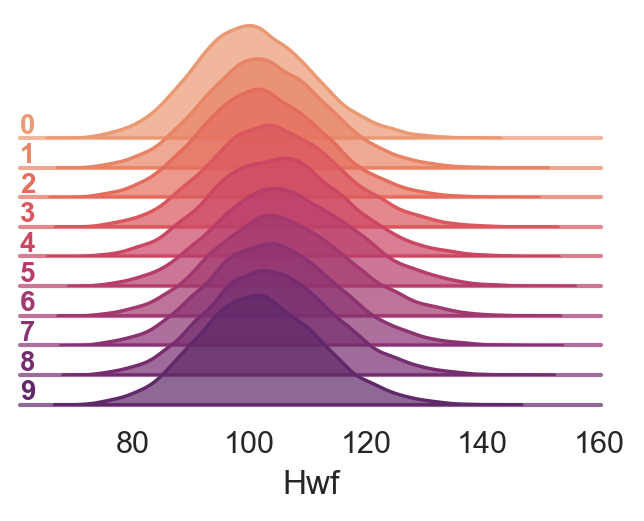

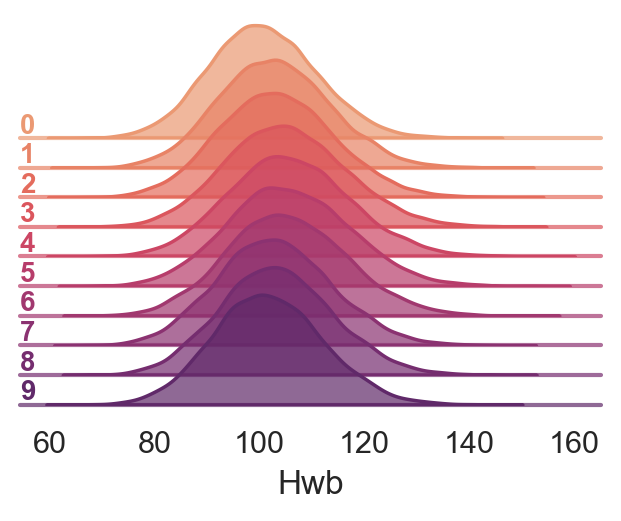

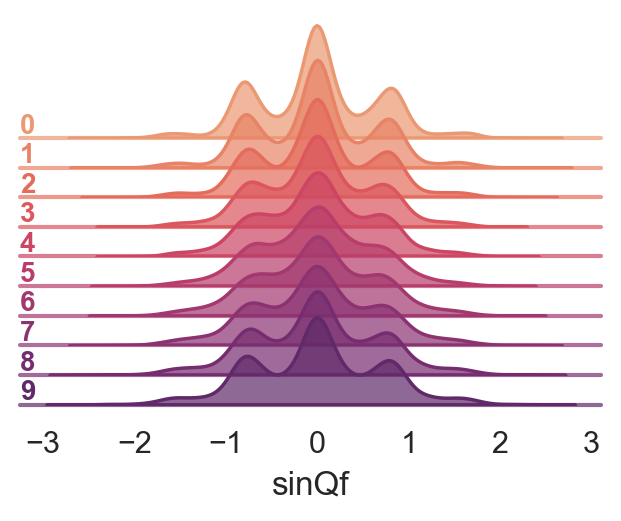

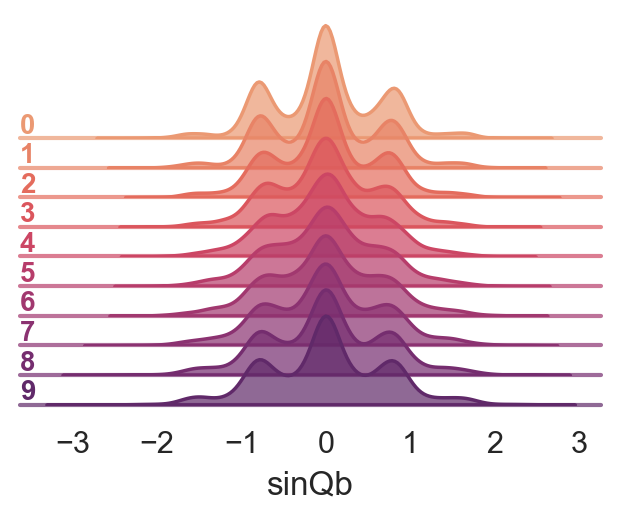

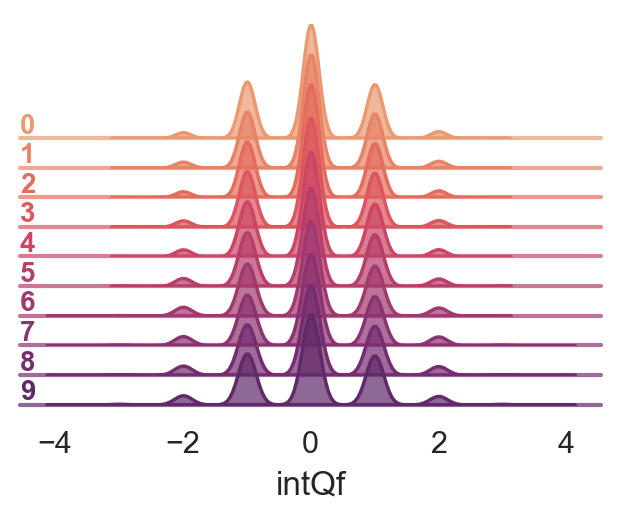

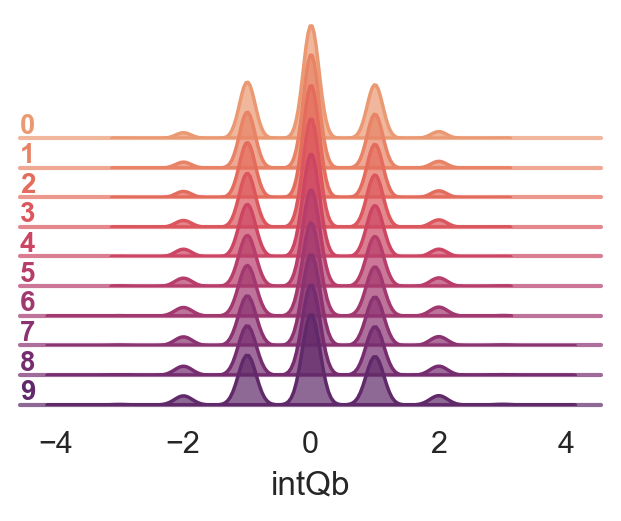

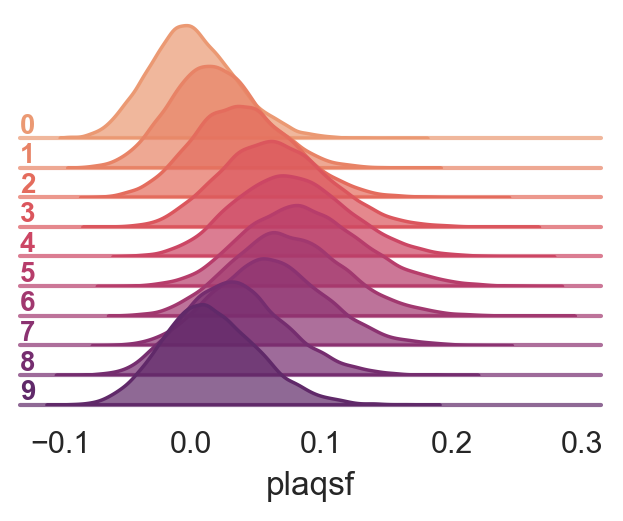

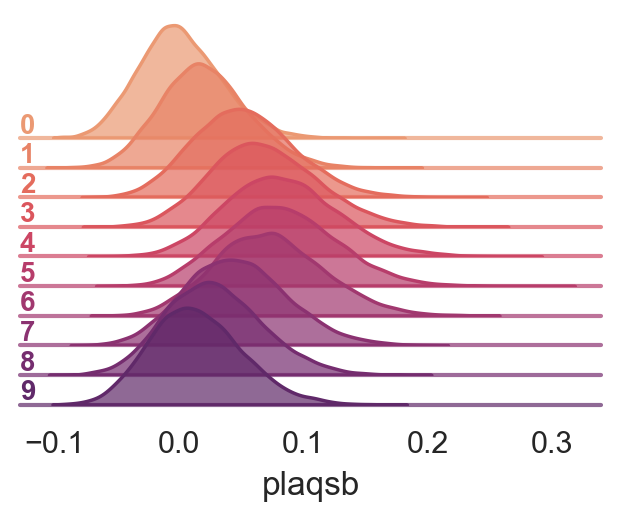

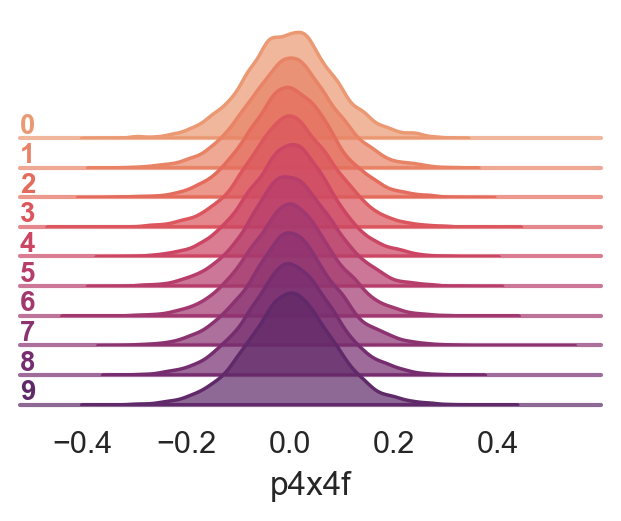

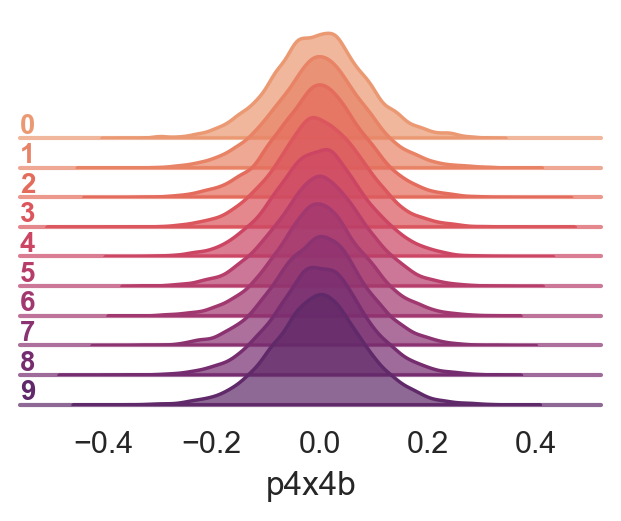

In [19]:
num_chains_to_plot = 16

run_dataset = inference_results.run_data.get_dataset(therm_frac=0.1)
for key, val in run_dataset.data_vars.items():
    if key not in to_plot:
        continue
        
    val = val[:num_chains_to_plot]
    fig, ax = plt.subplots(constrained_layout=True, figsize=set_size())
    _ = val.plot(ax=ax)
    
_ = make_ridgeplots(run_dataset, num_chains_to_plot)